In [5]:
import torch
from torch import nn, optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset

from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
import mpl_toolkits.mplot3d as plt3d
import matplotlib.animation as animation


from time import sleep
import time
import math

from PIL import Image
import os

os.environ['KMP_DUPLICATE_LIB_OK']='True'
use_cuda = torch.cuda.is_available()
device = torch.device("cpu")
# device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cpu


## LSTM

## Реализация на PyToch
##### https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html

In [6]:
class LSTM_net(nn.Module):
    def __init__(self,input_dim,hidden_dim,output_dim,layer_num):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.lstm = torch.nn.LSTM(input_dim, hidden_dim,layer_num,batch_first=True)
#         self.dr = torch.nn.Dropout2d(0.25)
        self.fc = torch.nn.Linear(hidden_dim,output_dim)
        
        
    def forward(self,inputs):
        x = inputs
        lstm_out,(hn,cn) = self.lstm(x)
        out = self.fc(lstm_out[:,-1,:])
        return out

https://github.com/shahroudy/NTURGB-D

#### Classes:
* sitting down
* clapping
* jump up
* cheer up
* hand waving

In [31]:
# skeletons = pd.read_csv("skels.csv")
skeletons = pd.read_csv("test_01.csv")

In [36]:
LABELS = {0: "sit down", 1: "clapping", 2:  "cheer up", 3: "hand waving", 4: "jump up", 
          5: "take off a hat", 6: "writing", 7: "put on glasses", 8: "tear up paper"}

In [32]:
skeletons.head()

,0,1,2,3,4,5,6,7,8,9,...,3366,3367,3368,3369,3370,3371,3372,3373,3374,labels
0,-0.080141,0.135073,3.691227,-0.058513,0.396866,3.606265,-0.037811,0.652906,3.509790,-0.066903,...,-0.066586,-0.194186,3.880914,0.103227,-0.183070,3.717531,0.180819,-0.130425,3.724300,0
1,-0.035358,0.192430,3.681518,-0.021036,0.422171,3.606487,-0.007186,0.646429,3.520689,-0.042399,...,-0.247820,0.496548,3.406900,-0.056666,0.495373,3.269386,-0.050549,0.490788,3.258667,1
2,0.233268,0.182226,3.738342,0.246664,0.427726,3.664138,0.258953,0.668395,3.579175,0.232204,...,0.341380,0.398297,3.464900,0.086362,0.484182,3.377581,0.137638,0.470977,3.347150,2
3,0.224168,0.188563,3.735721,0.225902,0.421312,3.664325,0.227259,0.649151,3.583410,0.194906,...,0.177972,0.426407,3.417228,0.066224,0.472247,3.390802,0.108203,0.448698,3.364467,2
4,0.229684,0.188112,3.749971,0.242151,0.432106,3.679358,0.252508,0.670998,3.597336,0.229758,...,-0.079222,0.348027,3.337667,0.085692,0.430705,3.427691,0.157289,0.475443,3.425417,3


## Dataloader

``` DataLoader(dataset, batch_size=1, shuffle=False, sampler=None,
           batch_sampler=None, num_workers=0, collate_fn=None,
           pin_memory=False, drop_last=False, timeout=0,
           worker_init_fn=None) ```

Класс Dataset и класс Dataloader помогают передавать собственные обучающие данные в сеть. 
Класс Dataset используется для обеспечения интерфейса для доступа ко всем обучающим или тестовым образцам в вашем наборе данных. Для этого необходимо реализовать как два обязательных метода, __getitem__ и __len_. 

In [10]:
class Test_Dataset(Dataset):
    def __init__(self):
        self.samples = list(range(0, 100)) ##генерируем случайные данные
        # Все подготовления данных происходят в инициализации:
        # - разделение данных на train/test/ validate
        # - аугментация (трансформация) данных 
        # - чтние аннотаций
        # - считывание по индексу

    def __len__(self):
        # # Возвращает данные и лейблы
        # - Применяет выбранные трансформации к данным
        # - отправление данных на гпу
        # - лучше возвращать данные как тензор или словарь
        return len(self.samples) #возвращаем данные

    def __getitem__(self, idx):
        return (self.samples[idx], label) 
    

In [115]:
class Skeleton_Dataset(Dataset):
    def __init__(self, file_path, transform=None):
        self.data = pd.read_csv(file_path)
        self.transform = transform


    def __len__(self):
        return len(self.data) 
    
    
    def __getitem__(self, idx):
        item = np.asarray(self.data.iloc[idx,:-1]).reshape(45,75)
        label = self.data.iloc[idx,-1]
        
        if self.transform != None:
            item = self.transform(item)
        return (item, label) 
    
def normalize(item):
#     return item
    return item / np.linalg.norm(item)

In [116]:
dataset = Skeleton_Dataset(file_path = "test_01.csv", transform=normalize)
# dataset = Skeleton_Dataset(file_path = "skels.csv", transform=None)

In [106]:
test_df = pd.read_csv("test_01.csv")

In [108]:
test_df.head(2)

,0,1,2,3,4,5,6,7,8,9,...,3366,3367,3368,3369,3370,3371,3372,3373,3374,labels
0,-0.080141,0.135073,3.691227,-0.058513,0.396866,3.606265,-0.037811,0.652906,3.509790,-0.066903,...,-0.066586,-0.194186,3.880914,0.103227,-0.183070,3.717531,0.180819,-0.130425,3.724300,0
1,-0.035358,0.192430,3.681518,-0.021036,0.422171,3.606487,-0.007186,0.646429,3.520689,-0.042399,...,-0.247820,0.496548,3.406900,-0.056666,0.495373,3.269386,-0.050549,0.490788,3.258667,1


In [107]:
test_df2 = normalize(test_df)

In [109]:
test_df2.head(2)

,0,1,2,3,4,5,6,7,8,9,...,3366,3367,3368,3369,3370,3371,3372,3373,3374,labels
0,-0.000023,0.000038,0.001038,-0.000016,0.000112,0.001014,-0.000011,0.000184,0.000987,-0.000019,...,-0.000019,-0.000055,0.001091,0.000029,-0.000051,0.001045,0.000051,-0.000037,0.001047,0.000000
1,-0.000010,0.000054,0.001035,-0.000006,0.000119,0.001014,-0.000002,0.000182,0.000990,-0.000012,...,-0.000070,0.000140,0.000958,-0.000016,0.000139,0.000919,-0.000014,0.000138,0.000916,0.000281


In [117]:
skel, lab = dataset.__getitem__(41)

In [93]:
type(skel)

numpy.ndarray

In [131]:
LABELS[lab]

'hand waving'

In [132]:
skel.shape

(45, 75)

In [133]:
skels_for_draw = skel.reshape(-1,25,3)

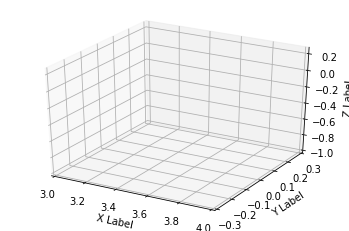

In [135]:
%matplotlib inline

bone_pairs = (
    (1, 2), (2, 21), (3, 21), (4, 3), (5, 21), (6, 5),
    (7, 6), (8, 7), (9, 21), (10, 9), (11, 10), (12, 11),
    (13, 1), (14, 13), (15, 14), (16, 15), (17, 1), (18, 17),
    (19, 18), (20, 19), (22, 23), (21, 21), (23, 8), (24, 25), (25, 12)
)

i = 0
# for for_draw in skels_for_draw:
i = i + 1
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for_draw = skels_for_draw[10]

for pair in bone_pairs:
    xs = for_draw[pair[0]-1][0], for_draw[pair[1]-1][0]
    ys = for_draw[pair[0]-1][1], for_draw[pair[1]-1][1]
    zs = for_draw[pair[0]-1][2], for_draw[pair[1]-1][2]

    line = plt3d.art3d.Line3D(zs, xs, ys)
    ax.add_line(line)


for x,y,z in for_draw:
    ax.scatter(z, x, y, color='black', marker='s')

    ax.set_ylim((-0.3, 0.3))
    ax.set_zlim((-1.0, 0.25))
    ax.set_xlim((3.0, 4.0))


    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')


    plt.show()

#     plt.savefig('pics_1/test_' +str(i)+'.png', bbox_inches='tight')
#     plt.clf()

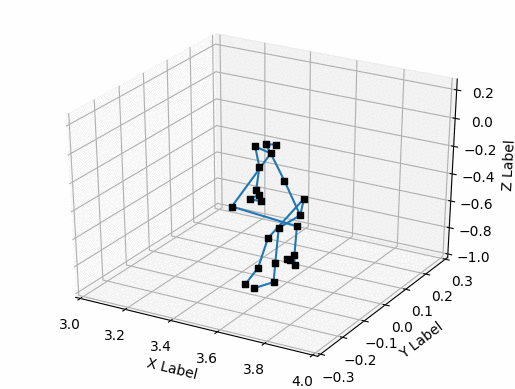

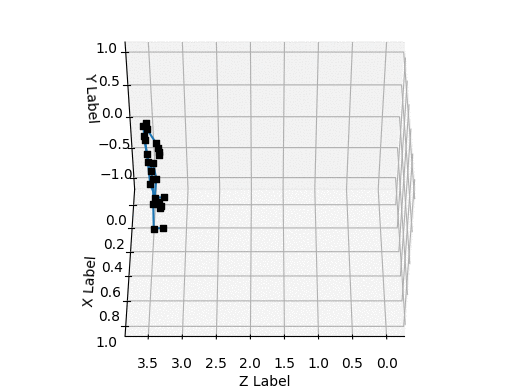

In [136]:
train_len = int(0.7*len(dataset))
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_len, len(dataset)-train_len])
train_loader = DataLoader(train_dataset, batch_size = 16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size = 16, shuffle=True)

In [158]:
n_hidden = 128
n_joints = 25*3
n_categories = len(LABELS)
n_layer = 2
rnn = LSTM_net(n_joints,n_hidden,n_categories,n_layer)
rnn.to(device)

LSTM_net(
  (lstm): LSTM(75, 128, num_layers=2, batch_first=True)
  (fc): Linear(in_features=128, out_features=9, bias=True)
)

In [159]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return LABELS[category_i], category_i

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [160]:
sket_tensor = torch.from_numpy(skel).unsqueeze(0).float()

In [161]:
sket_tensor.size()

torch.Size([1, 45, 75])

In [162]:
output = rnn(sket_tensor.to(device))

In [163]:
output.topk(9)

torch.return_types.topk(
values=tensor([[ 0.1277,  0.0589,  0.0496,  0.0347,  0.0174,  0.0169, -0.0343, -0.0428,
         -0.0599]], grad_fn=<TopkBackward>),
indices=tensor([[4, 2, 0, 5, 6, 8, 3, 7, 1]]))

In [164]:
%%time
criterion = nn.CrossEntropyLoss()
learning_rate = 0.0007
optimizer = optim.SGD(rnn.parameters(),lr=learning_rate,momentum=0.9)
epoches = 100
data_whole = len(train_loader.dataset)*epoches

all_losses = []
start = time.time()
counter = 0
for epoch in range(epoches):  
    current_loss = 0
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        
        inputs, labels = data[0].to(device), data[1].to(device)
    
        optimizer.zero_grad()
    
        output = rnn(inputs.float())
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step() 


        current_loss += loss.item()
        category = LABELS[int(labels[0])]

        if counter % 500 == 0:
            guess, guess_i = categoryFromOutput(output)
            correct = '✓' if guess == category else '✗ (%s)' % category
            data_done = i * len(inputs) + (epoch-1) * len(train_loader.dataset)
            if data_done < 0:
                data_done = 0
            data_done_perc = round(100. * data_done / data_whole, 1)
            ######сделать обновление графика loss по ходу обучению  
            print(f'epoch : {epoch} iter : {i} ({timeSince(start)}), data done: {data_done} from {data_whole} ({data_done_perc}%) / loss: {round(float(loss),4)} / {guess} {correct}')
            print(output.topk(5))
            print(labels.topk(5))
        
        counter = counter + 1
    if counter % 100 == 0:
        all_losses.append(current_loss / 25)
#         current_loss = 0
    

epoch : 0 iter : 0 (0m 0s), data done: 0 from 83200 (0.0%) / loss: 2.1957 / jump up ✗ (writing)
torch.return_types.topk(
values=tensor([[0.1277, 0.0586, 0.0493, 0.0350, 0.0177],
        [0.1279, 0.0584, 0.0496, 0.0347, 0.0176],
        [0.1278, 0.0586, 0.0495, 0.0347, 0.0177],
        [0.1279, 0.0586, 0.0492, 0.0349, 0.0176],
        [0.1278, 0.0587, 0.0494, 0.0349, 0.0177],
        [0.1278, 0.0587, 0.0492, 0.0350, 0.0177],
        [0.1278, 0.0587, 0.0492, 0.0350, 0.0177],
        [0.1280, 0.0585, 0.0495, 0.0347, 0.0176],
        [0.1279, 0.0584, 0.0495, 0.0348, 0.0176],
        [0.1278, 0.0586, 0.0492, 0.0350, 0.0177],
        [0.1278, 0.0586, 0.0494, 0.0349, 0.0177],
        [0.1277, 0.0586, 0.0492, 0.0350, 0.0178],
        [0.1279, 0.0585, 0.0493, 0.0350, 0.0176],
        [0.1278, 0.0585, 0.0493, 0.0349, 0.0177],
        [0.1278, 0.0586, 0.0491, 0.0350, 0.0178],
        [0.1278, 0.0586, 0.0493, 0.0350, 0.0177]], grad_fn=<TopkBackward>),
indices=tensor([[4, 2, 0, 5, 6],
        [4, 2

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide


epoch : 9 iter : 32 (0m 44s), data done: 7168 from 83200 (8.6%) / loss: nan / sit down ✗ (hand waving)
torch.return_types.topk(
values=tensor([[nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan]], grad_fn=<TopkBackward>),
indices=tensor([[0, 1, 2, 3, 4],
        [0, 1, 2, 3, 4],
        [0, 1, 2, 3, 4],
        [0, 1, 2, 3, 4],
        [0, 1, 2, 3, 4],
        [0, 1, 2, 3, 4],
        [0, 1, 2, 3, 4],
        [0, 1, 2, 3, 4],
        [0, 1, 2, 3, 4],
        [0, 1, 2, 3, 4],
        [0, 1, 2, 3, 

KeyboardInterrupt: 

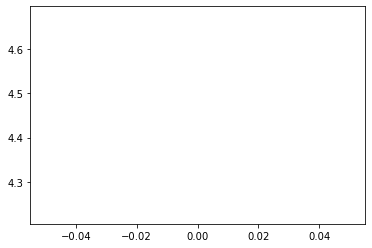

In [54]:
%matplotlib inline
plt.plot(list(range(0,len(all_losses))),all_losses)
plt.show()

In [55]:
total = 0
right = 0
counter = 0
with torch.no_grad():
    for i, data in enumerate(test_loader, 0):
        counter = counter + 1
        inputs, labels = data[0].to(device), data[1].to(device)   
        output = rnn(inputs.float())
        guess, guess_i = categoryFromOutput(output)
        category = LABELS[int(labels[0])]
        
        if guess == category:
            right = right + 1


print('Accuracy of the network:  ',  (100 * right / counter))

Accuracy of the network:   17.391304347826086


### Модуль transform

https://pytorch.org/docs/stable/torchvision/transforms.html

In [31]:

%matplotlib inline


img = Image.open('cat.png')

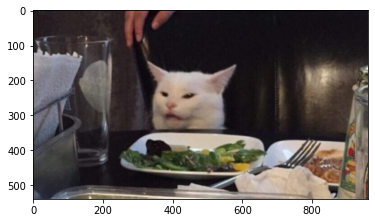

In [32]:
plt.imshow(img)
plt.show()

In [33]:
type(img)

PIL.PngImagePlugin.PngImageFile

In [34]:
img_0 = img.copy()

In [35]:
data_transforms = transforms.Compose([
        transforms.RandomResizedCrop(256)
        ])

In [36]:
img_crop = data_transforms(img_0)

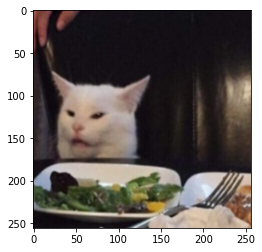

In [37]:
plt.imshow(img_crop)
plt.show()

In [38]:
img_1 = img.copy()

In [39]:
transformations = transforms.Compose([
    transforms.Resize(255),
    transforms.CenterCrop(224),
    transforms.RandomRotation(30)
])

In [40]:
img_center_crop = transformations(img_1)

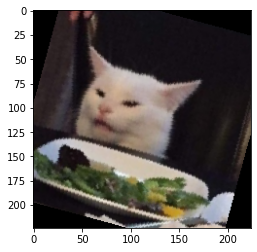

In [41]:
plt.imshow(img_center_crop)
plt.show()